# Approccio orientato ai dati

## Approccio connettivista: Perceptron

L'approccio connettivista prevede l'utilizzo di un modello di rete neurale, come un semplice perceptron, per imparare i modelli dei nomi. Le fasi comprendono:

1. **Codifica dei dati**: Convertire i nomi in un formato adatto all'addestramento della rete neurale (ad esempio, codifica a un punto).
2. **Addestramento del modello**: Addestrare un semplice perceptron sul set di dati. L'input potrebbe essere costituito da sequenze di caratteri e l'obiettivo potrebbe essere il carattere successivo del nome.
3. **Valutazione della perdita**: Utilizzare una funzione di perdita adeguata (come l'entropia incrociata categoriale) per valutare le prestazioni del modello e regolare i pesi di conseguenza.
4. **Generazione del nome**: Utilizzare il modello addestrato per prevedere i caratteri successivi, a partire da un carattere o una sequenza iniziale, per generare nuovi nomi.

In [29]:
# Load the dataset
file_path = 'names.txt'

# Read the file and process it for bigram frequency analysis
with open(file_path, 'r', encoding='utf-8') as file:
    names = file.read().splitlines()

print(names[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


### Fase 1: Preparazione dei dati

È necessario convertire i nomi in un formato che una rete neurale possa elaborare. Di solito questo comporta la codifica di ogni carattere in un formato numerico, come la codifica *one-hot*.

Una volta trovato il nostro alfabeto, procediamo in due fasi:

1. **Codifica dei caratteri**: Convertire ogni carattere in un indice numerico.
2. **One-hot encoding**: Convertire ogni indice in un vettore di zeri, tranne che per un 1 nella posizione dell'indice.

Per prima cosa troviamo il nostro alfabeto:

In [30]:
# Create a set of all unique characters in the names
unique_chars = set(''.join(names))
unique_chars = sorted(unique_chars)

# Pretty print the unique characters and the length of the set
print(f"{len(unique_chars)} caratteri univoci:", unique_chars)

26 caratteri univoci: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Creiamo un dizionario che **mappa ogni carattere in un indice numerico**.

#### Esempio:

I primi dieci elementi del dizionario sono i seguenti:
    
```python
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10}
```

In [31]:
# Create a dictionary to map each character to a unique integer. Add '.' as a special character
char_to_int = dict((c, i+1) for i, c in enumerate(unique_chars))
char_to_int['.'] = 0

#  Create a dictionary to convert back
int_to_char = {i: c for c, i in char_to_int.items()}

# Pretty print the dictionaries
print(char_to_int)
print(int_to_char)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Convertiamo ogni nome nella sua **rappresentazione numerica** con l'ausilio dei dizionari ``char_to_int`` e ``int_to_char``.

#### Esempio:

```python
'.emma.' --> [0, 5, 13, 13, 1, 0] --> '.emma.'
```


In [32]:
# For each name add a special char '.' at the beginning and the end
names = ['.' + name + '.' for name in names]

# Convert names to integer representation
int_names = [[char_to_int[char] for char in name] for name in names]

# Convert the first name to integer representation
print(names[0], '-->', int_names[0], '-->',
      ''.join([int_to_char[value] for value in int_names[0]]))

.emma. --> [0, 5, 13, 13, 1, 0] --> .emma.


Codifichiamo ogni nome in formato [one-hot-encoding](https://en.wikipedia.org/wiki/One-hot).
Potremmo usare quella di [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), il risultato sarebbe lo stesso.

Inoltre, stabiliamo qui e ora il numero massimo di caratteri che vogliamo considerare per ogni nome. Questo è necessario per creare un tensore di input di dimensioni fisse.

In [33]:
import numpy as np

# La dimensione della rappresentazione corrisponde alla lunghezza massima
max_name_length = max([len(name) for name in int_names])

# Codifica one-hot
n_chars = len(unique_chars)
one_hot_encoded = np.zeros(
    (len(int_names), max_name_length, n_chars+1), dtype=np.float32)
for i, name in enumerate(int_names):
    for j, char_int in enumerate(name):
        one_hot_encoded[i, j, char_int] = 1.0

print(one_hot_encoded.shape)

(32033, 17, 27)


#### Visualizzazione dei dati

Confrontiamo la rappresentazione di due nomi **in formato one-hot-encoding**.

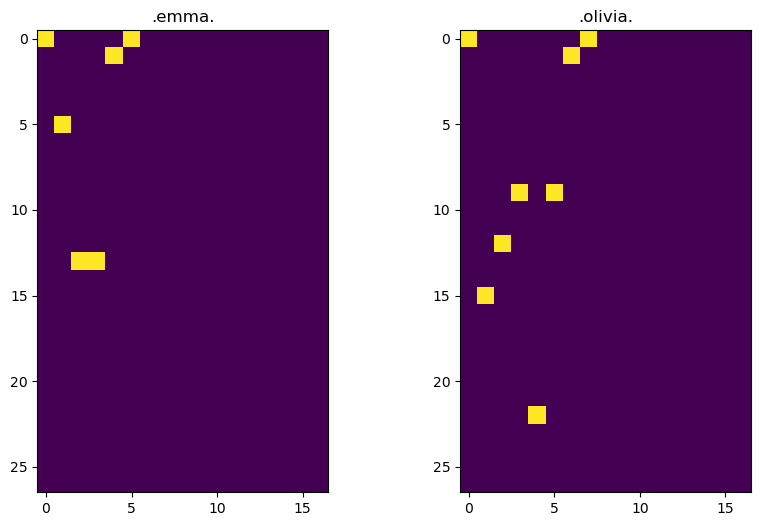

In [34]:
import matplotlib.pyplot as plt

# plot the first two names in the dataset
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title(names[0])
plt.imshow(one_hot_encoded[0].T)
plt.subplot(1, 2, 2)
plt.title(names[1])
plt.imshow(one_hot_encoded[1].T)
plt.show()

In [35]:
# Define the bigram frequency matrix
bigram_freq_matrix = np.zeros((n_chars+1, n_chars+1), dtype=np.float32)

# For each name in the dataset
for name in int_names:
    # For each bigram in the name
    for i in range(len(name)-1):
        # Get the first and second char integer representation
        char1 = name[i]
        char2 = name[i+1]
        # Increment the frequency count
        bigram_freq_matrix[char1, char2] += 1

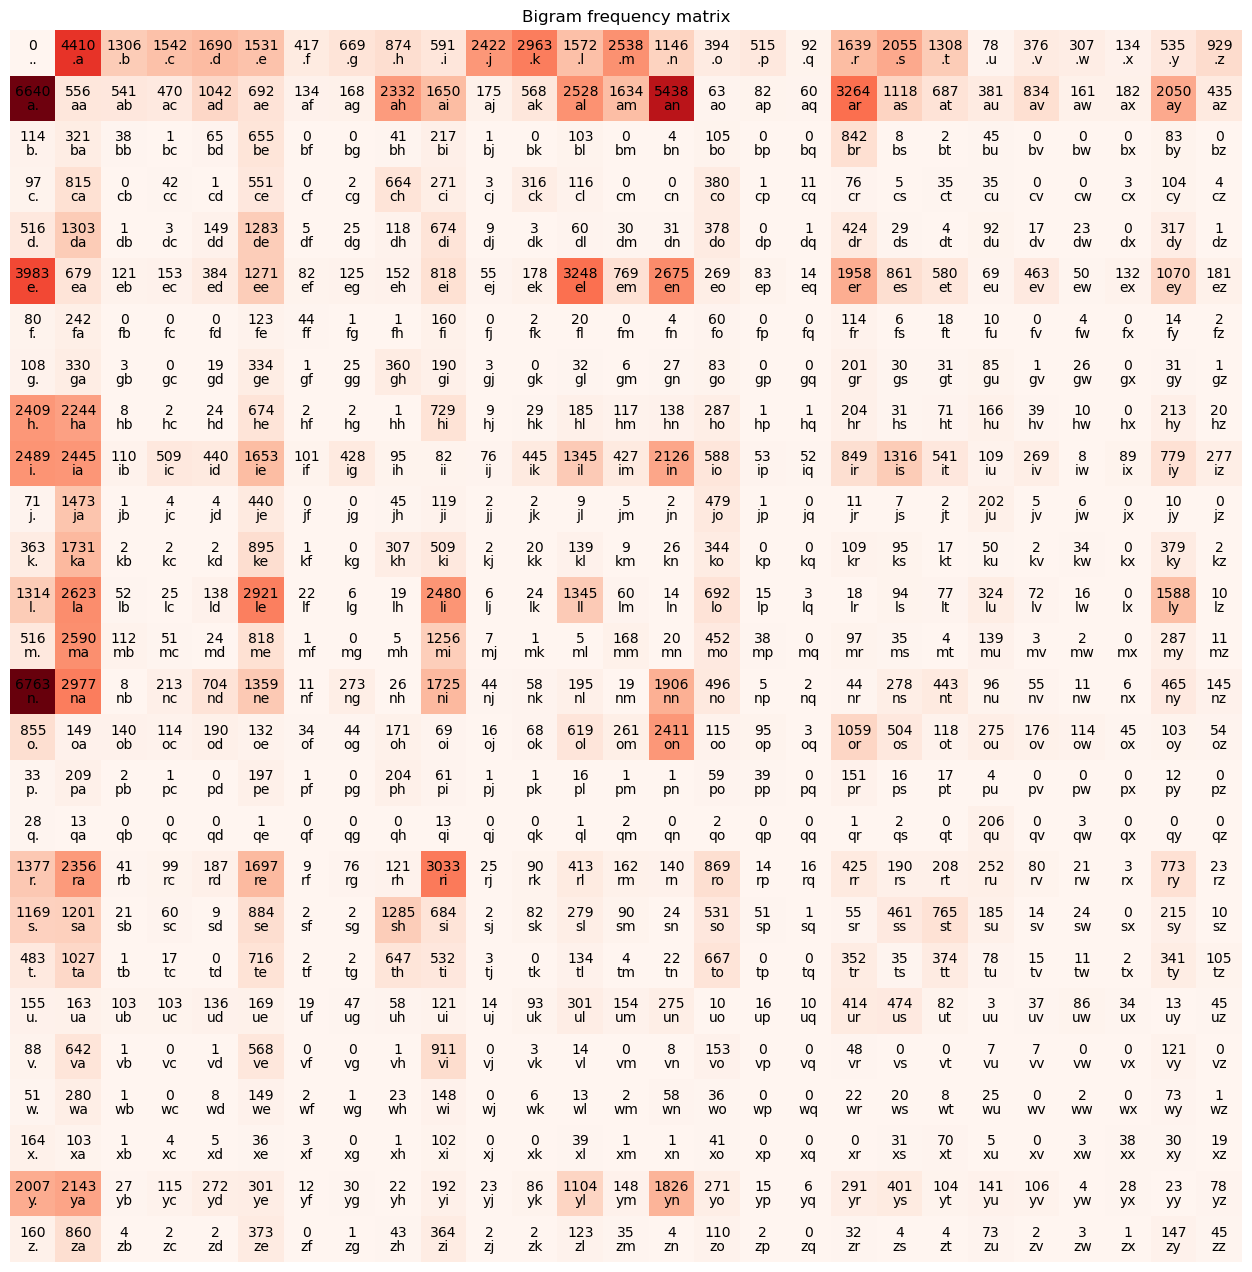

In [36]:
# Plot the matrix mapping the frequency of each bigram
plt.figure(figsize=(16, 16))
plt.title('Bigram frequency matrix')
plt.imshow(bigram_freq_matrix, cmap='Reds')
for i in range(27):
    for j in range(27):
        plt.text(
            j, i, f"{int_to_char[i]}{int_to_char[j]}", ha='center', va='top')
        plt.text(
            j, i, f"{bigram_freq_matrix[i, j]:.0f}", ha='center', va='bottom')
plt.xticks(range(27), list(unique_chars) + ['.'])
plt.yticks(range(27), list(unique_chars) + ['.'])
plt.axis('off')
plt.show()

Esploriamo **i bigrammi** e come rappresentano i nomi, in termini di probabilità, e attraverso il loro valore di *log-likelihood*.

#### Esempio:

Quale è la *likelihood* che un nome inizi con la lettera 'e'?

In [37]:
bigram_prob_matrix = np.zeros((n_chars+1, n_chars+1), dtype=np.float32)

# Compute the probability matrix
for i in range(n_chars+1):
    # Get the total count of bigrams starting with char i
    total_count = bigram_freq_matrix[i].sum()
    # If the total count is not zero
    if total_count != 0:
        # Compute the probability of each bigram starting with char i
        bigram_prob_matrix[i] = bigram_freq_matrix[i] / total_count

In [38]:
# Leggiamo la prima riga della matrice di frequenza dei bigrammi che iniziamo con il carattere '.'.
print("Frequenze del primo carattere uguale ad 'e' in un nome",
      bigram_freq_matrix[0][char_to_int['e']])

# Probabilità che il primo carattere sia esattamente 'e'
print("Probabilità che il primo carattere sia esattamente 'e'",
      bigram_prob_matrix[0][char_to_int['e']])

Frequenze del primo carattere uguale ad 'e' in un nome 1531.0
Probabilità che il primo carattere sia esattamente 'e' 0.04779446


#### Esempio:

**Ancora un approccio frequentista**: generare un nuovo nome significa pescare un carattere alla volta, in base alla probabilità che sia il successivo.

In [39]:
# Peschiamo dalla distribuzione multinomiale
import torch
g = torch.Generator().manual_seed(42)

for i in range(5):
    multinomial_pick = torch.multinomial(
        torch.tensor(bigram_prob_matrix[i]), num_samples=1, generator=g).item()
    char_pick = int_to_char[multinomial_pick]
    print(
        f"Peschiamo il carattere n.{i+1} dalla distribuzione di probabilità: '{char_pick}'")

Peschiamo il carattere n.1 dalla distribuzione di probabilità: 'a'
Peschiamo il carattere n.2 dalla distribuzione di probabilità: 'n'
Peschiamo il carattere n.3 dalla distribuzione di probabilità: 'u'
Peschiamo il carattere n.4 dalla distribuzione di probabilità: 'h'
Peschiamo il carattere n.5 dalla distribuzione di probabilità: 'e'


Produciamo un nome con **un numero arbitrario di caratteri**.

#### Esempio:

```python
Nome generato n.1: 'anugeenvi.'
Nome generato n.2: 's.'
Nome generato n.3: 'mabian.'
Nome generato n.4: 'dan.'
Nome generato n.5: 'stan.'
```

In [40]:
# Peschiamo dalla distribuzione multinomiale
import torch
g = torch.Generator().manual_seed(42)


def generate_name():
    int_pick = 0
    gen_name = []
    while True:
        p = torch.tensor(bigram_prob_matrix[int_pick])
        int_pick = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g).item()
        char_pick = int_to_char[int_pick]
        gen_name.append(char_pick)
        if char_pick == '.':
            break
    return ''.join(gen_name)


for i in range(5):
    print(f"Nome generato n.{i+1}: '{generate_name()}'")

Nome generato n.1: 'anugeenvi.'
Nome generato n.2: 's.'
Nome generato n.3: 'mabian.'
Nome generato n.4: 'dan.'
Nome generato n.5: 'stan.'


### Passo 2: Progettazione del percettrone

È possibile progettare un semplice perceptron usando le librerie `numpy` e `pytorch`.

In [41]:
input_size = len(char_to_int)  # Number of unique characters
output_size = len(char_to_int)  # Same as the number of unique characters

print(f"Input size: {input_size}, Output size: {output_size}")

Input size: 27, Output size: 27


In [42]:
import numpy as np

# Initialize weights and biases
weights = np.random.normal(0.0, pow(input_size, -0.5),
                           (input_size, output_size))
biases = np.zeros(output_size)

print(f"Shape of weights: {weights.shape}")
print(f"Shape of biases: {biases.shape}")

Shape of weights: (27, 27)
Shape of biases: (27,)


#### Massimizzare la *likelihood* dei dati rispetto ai parametri del modello

1. **Likelihood**: La *likelihood* (verosimiglianza) di un modello statistico è una funzione dei suoi parametri rispetto ai dati. Misura quanto siano probabili i dati osservati, dati i parametri del modello.
2. **Massimizzare la *likelihood***: L'obiettivo è trovare i parametri del modello che rendono più probabili i dati osservati. Questo è il principio di massima verosimiglianza.

In [43]:
# Define a function for likelihood (example with a normal distribution)
import numpy as np
from scipy.stats import norm


def likelihood(data, mean, std_dev):
    return np.prod(norm.pdf(data, mean, std_dev))


# Example of likelihood computation
likelihood([1, 2, 3], 2, 1)

0.02335800330543158

#### Massimizzare la *likelihood* equivale a massimizzare la *log likelihood*

3. **log likelihood**: Il logaritmo della funzione di verosimiglianza semplifica il problema di ottimizzazione, soprattutto quando si ha a che fare con prodotti di probabilità, cosa comune nelle funzioni di verosimiglianza.

In [44]:
def log_likelihood(data, mean, std_dev):
    return np.sum(np.log(norm.pdf(data, mean, std_dev)))


# Example of log-likelihood computation
log_likelihood([1, 2, 3], 2, 1)

-3.756815599614018

### Massimizzare la *log likelihood* equivale a minimizzare la *negative log likelihood*

4. **Negative Log Likelihood**: La massimizzazione del log likelihood è equivalente alla minimizzazione del suo negativo. Questo viene fatto spesso perché molti algoritmi di ottimizzazione sono progettati per minimizzare le funzioni.

In [45]:
def negative_log_likelihood(data, mean, std_dev):
    return -log_likelihood(data, mean, std_dev)


# Example of negative log-likelihood computation
negative_log_likelihood([1, 2, 3], 2, 1)

3.756815599614018

#### Massimizzare la *negative log likelihood* equivale a minimizzare la *average negative log likelihood*

5. **Average Negative Log Likelihood**: Nei casi di insiemi di dati di grandi dimensioni, è comune considerare la media della verosimiglianza logica negativa, in quanto ha una scala migliore e fornisce un valore più interpretabile.


In [46]:
def avg_negative_log_likelihood(data, mean, std_dev):
    return negative_log_likelihood(data, mean, std_dev) / len(data)


# Example of average negative log-likelihood computation
avg_negative_log_likelihood([1, 2, 3], 2, 1)

1.252271866538006

#### Proprietà logaritmica

6. **Logarithmic Property**: Il logaritmo di un prodotto è la somma dei logaritmi, il che semplifica i calcoli e previene l'underflow numerico nei computer.

In [47]:
# Logarithmic property example
a, b, c = 0.1, 0.2, 0.3
log_product = np.log(a * b * c)
log_sum = np.log(a) + np.log(b) + np.log(c)

# Print values of logs
print(f"Log product: {log_product}")
print(f"Log sum: {log_sum}")

Log product: -5.115995809754082
Log sum: -5.115995809754081


#### Esempio

Calcoliamo le *likelihood* per il nostro nome.

``` python
1: '.s' (0.0642, -2.7465)
2: 'st' (0.0944, -2.3605)
3: 'te' (0.1285, -2.0515)
4: 'ef' (0.0040, -5.5177)
5: 'fa' (0.2674, -1.3190)
6: 'an' (0.1605, -1.8296)
7: 'no' (0.0271, -3.6096)
8: 'o.' (0.1078, -2.2278)
Likelihood di '.stefano.': 0.8538
Log-likelihood di '.stefano.': -21.6621
Negative log-likelihood di '.stefano.': 21.6621
Average negative log-likelihood di '.stefano.': -2.7078
```

In [77]:
bigram_prob_tensor = torch.from_numpy(bigram_prob_matrix)
likelihood = 0.0
log_likelihood = 0.0

i = 0
name = ".stefano."
for c1, c2 in zip(name, name[1:]):
    i1 = char_to_int[c1]
    i2 = char_to_int[c2]
    p = bigram_prob_tensor[i1][i2]
    log_p = torch.log(p)
    likelihood += p
    log_likelihood += log_p
    i += 1
    print(f"{i}: '{c1}{c2}' ({p:.4f}, {log_p:.4f})")

print(f"Likelihood di '{name}': {likelihood:.4f}")
print(f"Log-likelihood di '{name}': {log_likelihood:.4f}")
print(f"Negative log-likelihood di '{name}': {-log_likelihood:.4f}")
print(
    f"Average negative log-likelihood di '{name}': {log_likelihood / i:.4f}")

1: '.s' (0.0642, -2.7465)
2: 'st' (0.0944, -2.3605)
3: 'te' (0.1285, -2.0515)
4: 'ef' (0.0040, -5.5177)
5: 'fa' (0.2674, -1.3190)
6: 'an' (0.1605, -1.8296)
7: 'no' (0.0271, -3.6096)
8: 'o.' (0.1078, -2.2278)
Likelihood di '.stefano.': 0.8538
Log-likelihood di '.stefano.': -21.6621
Negative log-likelihood di '.stefano.': 21.6621
Average negative log-likelihood di '.stefano.': -2.7078


Creiamo il **training set** di *bigrams* e il target set di *bigrams* successivi. Per ora consideriamo solo il primo nome.

In [102]:
# create the training set of bigrams (x,y)
inputs, targets = [], []

for name in names[:1]:
    for c1, c2 in zip(name, name[1:]):
        i1 = char_to_int[c1]
        i2 = char_to_int[c2]
        print(f"'{c1}{c2}'")
        inputs.append(i1)
        targets.append(i2)

inputs = torch.tensor(inputs)
print(inputs)
targets = torch.tensor(targets)
print(targets)

'.e'
'em'
'mm'
'ma'
'a.'
tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


Ancora una volta, **trasformiamo il nostro input** in una rappresentazione *one-hot*, questa volta con `pytorch`. Invece del numero massimo di caratteri, usiamo la grandezza della matrice di probabilità.

Shape of encoded inputs: torch.Size([5, 27])


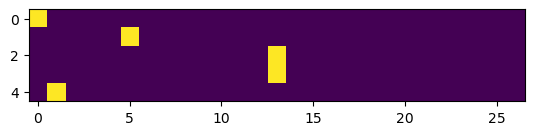

In [86]:
import torch.nn.functional as F

encoded_inputs = F.one_hot(inputs, num_classes=27).float()

print(f"Shape of encoded inputs: {encoded_inputs.shape}")
plt.imshow(encoded_inputs)

Shape of W: torch.Size([27, 27])
Shape of outputs: torch.Size([5, 27])
tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047,
         -0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624,
          1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806,
          1.2791,  1.2964,  0.6105],
        [ 0.5760,  1.1415,  0.0186, -1.8058,  0.9254, -0.3753,  1.0331, -0.6867,
          0.6368, -0.9727,  0.9585,  1.6192,  1.4506,  0.2695, -0.2104, -0.7328,
          0.1043,  0.3488,  0.9676, -0.4657,  1.6048, -2.4801, -0.4175, -1.1955,
          0.8123, -1.9006,  0.2286],
        [-0.3303, -0.7939,  0.3752,  0.0879, -1.2415, -0.3203, -0.8444, -0.5513,
          1.9890,  1.9003,  1.6951,  0.0281, -0.1754, -1.7735, -0.7046, -0.3947,
          1.8868, -0.2184,  0.1663,  2.1442,  1.7046,  0.3459,  0.6425, -0.2040,
          0.6854, -0.1397, -1.1808],
        [-0.3303, -0.7939,  0.3752,  0.0879, -1.2415, -0.3203, -0.8444, -0.5513,
        

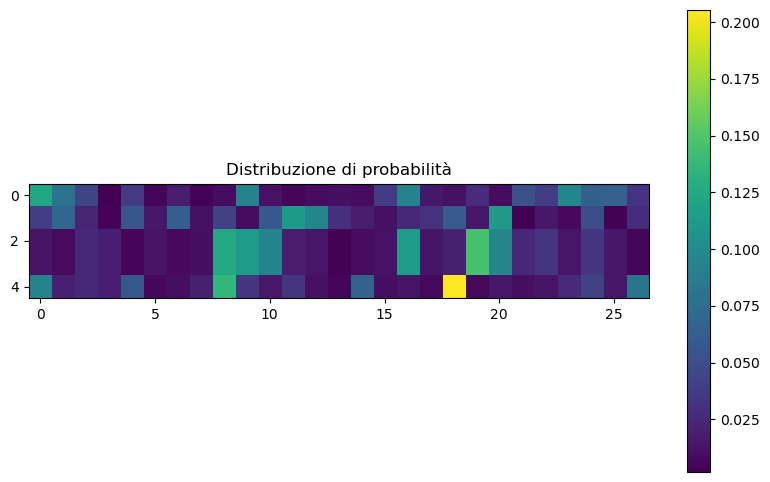

In [120]:
import torch

g = torch.Generator().manual_seed(42)

# Inizializziamo i pesi
input_dim = 27
output_dim = 27
W = torch.randn((input_dim, output_dim), generator=g)
print(f"Shape of W: {W.shape}")

# Un semplice forward pass del perceptron
outputs = encoded_inputs @ W
print(f"Shape of outputs: {outputs.shape}")
print(outputs)

# Calcoliamo la distribuzione di probabilità
counts = outputs.exp()
print(f"Shape of counts: {counts.shape}")
print(counts)

# Normalizziamo la distribuzione di probabilità
probs = counts / counts.sum(dim=1, keepdim=True)
print(f"Shape of probs: {probs.shape}")
print(probs)

# Plot la distribuzione di probabilità
plt.figure(figsize=(10, 6))
plt.title('Distribuzione di probabilità')
plt.imshow(probs)
plt.colorbar()
plt.show()

Le ultime due righe di codice, il calcolo della distribuzione di probabilità e la normalizzazione, prendono il nome, insieme, di **softmax**.

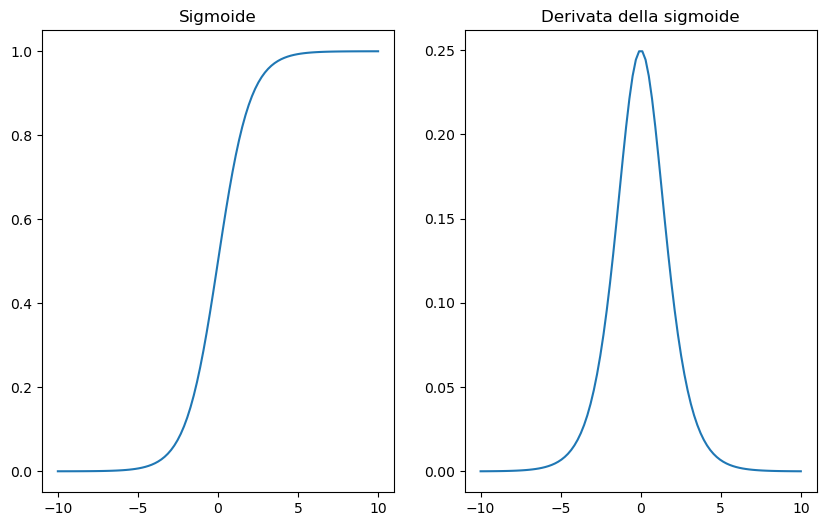

In [109]:
import numpy as np


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return x * (1 - x)


# Esempio di uso della sigmoide
x = np.linspace(-10, 10, 100)
y = sigmoid(x)
dy = sigmoid_derivative(y)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title("Sigmoide")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Derivata della sigmoide")
plt.plot(x, dy)
plt.show()

### Fase 3: addestramento del modello

L'addestramento del perceptron comporta la regolazione dei pesi in base all'errore tra l'uscita prevista e quella effettiva. Questa operazione viene tipicamente eseguita utilizzando la *backpropagation* e un algoritmo di ottimizzazione come la discesa del gradiente.

#### Esempio

Per ciascun bigramma del dataset (per ora contiene solo il primo nome):

1. **Calcoliamo l'output**: Calcoliamo l'output del modello per il bigramma corrente.
2. **Calcoliamo la distribuzione di probabilità**: Calcoliamo la distribuzione di probabilità per il bigramma corrente.
3. **Calcoliamo la *negative log likelihood***: Calcoliamo la *negative log likelihood* per il bigramma corrente.
4. **Calcoliamo la *average negative log likelihood***: Teniamo traccia per calcolare la *average negative log likelihood* al termine dell'addestramento.

```python
------------------------------------------------------------------------------------------------
Bigram n.1: ".e"
Input: "."
Output: tensor(0.0934)
Probabilità assegnata dal modello al carattere "e": 0.0052
Negative log likelihood: 5.2568
------------------------------------------------------------------------------------------------
Bigram n.2: "em"
Input: "e"
Output: tensor(0.0793)
Probabilità assegnata dal modello al carattere "m": 0.0292
Negative log likelihood: 3.5344
------------------------------------------------------------------------------------------------
Bigram n.3: "mm"
Input: "m"
Output: tensor(0.0227)
Probabilità assegnata dal modello al carattere "m": 0.0029
Negative log likelihood: 5.8390
------------------------------------------------------------------------------------------------
Bigram n.4: "ma"
Input: "m"
Output: tensor(0.0187)
Probabilità assegnata dal modello al carattere "a": 0.0078
Negative log likelihood: 4.8595
------------------------------------------------------------------------------------------------
Bigram n.5: "a."
Input: "a"
Output: tensor(0.0050)
Probabilità assegnata dal modello al carattere ".": 0.0934
Negative log likelihood: 2.3710
============================================================================================================
Average negative log likelihood (AKA LOSS): 4.372130
``````

In [159]:
import torch

g = torch.Generator().manual_seed(42)

# Inizializziamo i pesi
W = torch.randn((input_dim, output_dim), generator=g)

negative_log_likelihoods = torch.zeros(5)
for i in range(5):
    x = inputs[i].item()
    y = targets[i].item()
    print('--------'*12)
    print(
        f'Bigram n.{i+1}: "{int_to_char[x]}{int_to_char[y]}"')
    print(f'Input: "{int_to_char[x]}"')
    print('Output:', probs[i])

    outputs = encoded_inputs[i] @ W
    counts = outputs.exp()
    probs = counts / counts.sum()
    p = probs[y]
    print(
        f'Probabilità assegnata dal modello al carattere "{int_to_char[y]}": {p.item():.4f}')

    negative_log_likelihood = -torch.log(p)
    print(f'Negative log likelihood: {negative_log_likelihood.item():.4f}')

    negative_log_likelihoods[i] = negative_log_likelihood

print('========='*12)
print(
    f'Average negative log likelihood (AKA LOSS): {negative_log_likelihoods.mean().item():4f}')

------------------------------------------------------------------------------------------------
Bigram n.1: ".e"
Input: "."
Output: tensor(0.0934)
Probabilità assegnata dal modello al carattere "e": 0.0052
Negative log likelihood: 5.2568
------------------------------------------------------------------------------------------------
Bigram n.2: "em"
Input: "e"
Output: tensor(0.0793)
Probabilità assegnata dal modello al carattere "m": 0.0292
Negative log likelihood: 3.5344
------------------------------------------------------------------------------------------------
Bigram n.3: "mm"
Input: "m"
Output: tensor(0.0227)
Probabilità assegnata dal modello al carattere "m": 0.0029
Negative log likelihood: 5.8390
------------------------------------------------------------------------------------------------
Bigram n.4: "ma"
Input: "m"
Output: tensor(0.0187)
Probabilità assegnata dal modello al carattere "a": 0.0078
Negative log likelihood: 4.8595
--------------------------------------------

**Generalizziamo l'addestramento** per tutti i nomi del dataset. Prima però, dobbiamo definire la nostra politica di **aggiornamento dei pesi**. 

In [185]:
import torch

g = torch.Generator().manual_seed(42)

# Inizializziamo i pesi, questa volta teniamo traccia del gradiente
W = torch.randn((input_dim, output_dim), generator=g, requires_grad=True)
# Forward pass
outputs = encoded_inputs @ W
counts = outputs.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
loss = -torch.log(probs[range(len(targets)), targets]).mean()

print(f"Loss: {loss.item():.4f}")

# Backward pass
W.grad = None
loss.backward()

print(f"Valore di W:\n{W[0]}")
print(f"Gradiente di W:\n{W.grad[0]}")

Loss: 4.3721
Valore di W:
tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047,
        -0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624,
         1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806,
         1.2791,  1.2964,  0.6105], grad_fn=<SelectBackward0>)
Gradiente di W:
tensor([ 0.0246,  0.0159,  0.0088,  0.0004,  0.0071, -0.1990,  0.0034,  0.0007,
         0.0017,  0.0186,  0.0024,  0.0009,  0.0017,  0.0020,  0.0017,  0.0077,
         0.0185,  0.0031,  0.0022,  0.0056,  0.0017,  0.0105,  0.0080,  0.0192,
         0.0129,  0.0131,  0.0066])


In [186]:
W.data += -0.1 * W.grad
print(f"Nuovo valore di W:\n{W[0]}")
print(f"Gradiente di W:\n{W.grad[0]}")

Nuovo valore di W:
tensor([ 1.9245,  1.4857,  0.8998, -2.1056,  0.6777, -1.2146, -0.0434, -1.6047,
        -0.7523,  1.6469, -0.3927, -1.4037, -0.7281, -0.5596, -0.7690,  0.7617,
         1.6405, -0.1599, -0.4976,  0.4390, -0.7583,  1.0773,  0.8000,  1.6787,
         1.2778,  1.2951,  0.6098], grad_fn=<SelectBackward0>)
Gradiente di W:
tensor([ 0.0246,  0.0159,  0.0088,  0.0004,  0.0071, -0.1990,  0.0034,  0.0007,
         0.0017,  0.0186,  0.0024,  0.0009,  0.0017,  0.0020,  0.0017,  0.0077,
         0.0185,  0.0031,  0.0022,  0.0056,  0.0017,  0.0105,  0.0080,  0.0192,
         0.0129,  0.0131,  0.0066])


#### Generalizzazione dell'addestramento

1. **Creiamo il dataset completo**: Creiamo il dataset completo, con tutti i nomi.
2. **Calcoliamo l'output**: Calcoliamo l'output del modello per il dataset di bigrammi.
3. **Calcoliamo la loss**: Calcoliamo la loss cioè la *average negative log likelihood* per tutto il dataset.
4. **Aggiorniamo i pesi**: Aggiorniamo i pesi del modello in base alla loss.

Possiamo ripetere questo processo per un certo numero di iterazione (**epoche**), o fino a quando la loss non raggiunge un valore minimo.

Generiamo i nomi con il modello addestrato.

In [188]:
import torch
g = torch.Generator().manual_seed(42)

for _ in range(5):
    name = []
    i = 0
    while True:
        encoded_inputs = F.one_hot(torch.tensor([i]), num_classes=27).float()
        outputs = encoded_inputs @ W
        counts = outputs.exp()
        p = counts / counts.sum(1, keepdims=True)
        i = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g).item()
        name.append(int_to_char[i])
        if i == 0:
            break
    print(''.join(name))

.
.
ugedyvtgl.
fabiduedxfmsbnwmsglaypglcuemshcgcmin.
upjccupdsgldkzc.
